In [1]:
import torchvision
print(torchvision.__version__)
%matplotlib inline

0.21.0+cu124


In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive') # only run when creating notebook for the first time
sys.path.append('/content/drive/MyDrive/final_project')

Mounted at /content/drive


In [3]:
# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'final_project'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['project_env.yaml', 'train_model.py', 'collect_code.sh', 'Test_baseTrainer.ipynb', 'tsne_results.pkl', 'Test_Trainer_callback.ipynb', 'callbacks', 'logs', 'models', 'tutorials', 'configs', 'data_loader', 'data', 'trainers', 'tests', 'losses', 'utils', 'Test_Trainer_callback_RNA_seq.ipynb', 'Test_Trainer_callback_RNA_seq_CNN.ipynb']


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
from utils import Config
from data_loader import MultiOmicsDataset, create_dataloaders

In [6]:
# # Reload all modules every time before executing code
%load_ext autoreload
%autoreload 2

### 7. Run pytest

In [7]:
# %%bash
# pytest -v

In [8]:
import json
from pathlib import Path
from sklearn.metrics import classification_report, accuracy_score
import torch

In [9]:
from utils import Config
from data_loader import MultiOmicsDataset, create_dataloaders
from models import MultiOmicsClassifier, SingleOmicsClassifier
from trainers import BaseTrainer
from losses import MultiOmicsLoss, RNASeqLoss

In [10]:
from trainers import CallbackTrainer
from callbacks import LossRecorderCallback, TSNERecorderCallback
from callbacks import AccuracyRecorderCallback
from callbacks import AttentionLoggerCallback
from utils import plot_tsne, plot_loss

def extract_latent(outputs):
    """Example: Extract latent representation from your specific model outputs"""
    return outputs['latent_rep']  # Replace with your actual latent key
    # Or if using concatenated features:
    # return torch.cat([outputs['mirna_latent'], outputs['rna_latent']], dim=1)

In [11]:
def get_training_parameters(trainer, include_model_info=False, include_optimizer_state=False):
    """Extracts all relevant training parameters in a structured dictionary.

    Args:
        trainer: BaseTrainer instance
        include_model_info: Whether to include model architecture details
        include_optimizer_state: Whether to include optimizer state details

    Returns:
        Dictionary containing all training parameters
    """
    params = {
        "training": {
            "device": str(trainer.device),
        },
        "loss": {
            "type": type(trainer.loss_fn).__name__,
            "beta": getattr(trainer.loss_fn, 'target_beta', None),
            "use_focal": getattr(trainer.loss_fn, 'use_focal', None),
            "focal_gamma": getattr(trainer.loss_fn, 'focal_gamma', None),
            "label_smoothing": getattr(trainer.loss_fn, 'label_smoothing', None),
            "kl_epsilon": getattr(trainer.loss_fn, 'kl_epsilon', None)
        },
        "optimizer": {
            "type": type(trainer.optimizer).__name__,
            "lr": trainer.optimizer.param_groups[0]['lr'],
            "betas": trainer.optimizer.param_groups[0].get('betas', None),
            "eps": trainer.optimizer.param_groups[0].get('eps', None),
            "weight_decay": trainer.optimizer.param_groups[0].get('weight_decay', None)
        }
    }

    if include_model_info:
        params["model"] = {
            "type": type(trainer.model).__name__,
            "total_parameters": sum(p.numel() for p in trainer.model.parameters()),
            "trainable_parameters": sum(p.numel() for p in trainer.model.parameters()
                                      if p.requires_grad),
            "architecture": str(trainer.model)  # This shows the model structure
        }

    if include_optimizer_state:
        params["optimizer"]["state"] = {
            "momentum_buffer": any('momentum_buffer' in p for p in trainer.optimizer.state.values())
        }


    return params

# RNA-seq Only Models

In [12]:
config = Config.from_yaml("/content/drive/MyDrive/final_project/configs/data_rna_config.yaml")

dataset = MultiOmicsDataset(config)
dataloaders = create_dataloaders(dataset, config)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [13]:
#Apoorva
rna_exp_dim = 13054
latent_dim = 16
num_classes = 5

# Instantiate model
singleomics_model = SingleOmicsClassifier(
    rna_exp_dim=rna_exp_dim,
    latent_dim=latent_dim,
    num_classes=num_classes
)

In [14]:
trainer = BaseTrainer(
    model=singleomics_model,
    optimizer=torch.optim.Adam(singleomics_model.parameters(), lr=1e-3),
    loss_fn=RNASeqLoss(),
    device=device
)

trainer.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=10)

Validation: 100%|██████████| 2/2 [00:00<00:00,  6.49it/s]



📆 Epoch 1/10
🧮 Train Loss: 1.4596
🧪 Val Loss:   6.0756


Training: 100%|██████████| 5/5 [00:00<00:00, 12.61it/s, loss=0.955]


step    10 | loss: 1.2748 | ce: 0.9871 | kl: 37.7750 | beta: 0.0076


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.73it/s]



📆 Epoch 2/10
🧮 Train Loss: 1.2398
🧪 Val Loss:   5.1760


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]



📆 Epoch 3/10
🧮 Train Loss: 1.2718
🧪 Val Loss:   3.5624


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]



📆 Epoch 4/10
🧮 Train Loss: 1.2436
🧪 Val Loss:   3.5165


Training: 100%|██████████| 5/5 [00:00<00:00, 12.45it/s, loss=0.888]


step    30 | loss: 1.1233 | ce: 0.4766 | kl: 84.1120 | beta: 0.0077


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]



📆 Epoch 5/10
🧮 Train Loss: 1.0763
🧪 Val Loss:   5.3973


Training: 100%|██████████| 5/5 [00:00<00:00,  8.27it/s, loss=1.69]


step    40 | loss: 1.6940 | ce: 0.8718 | kl: 106.4538 | beta: 0.0077


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]



📆 Epoch 6/10
🧮 Train Loss: 1.2462
🧪 Val Loss:   9.0580


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]



📆 Epoch 7/10
🧮 Train Loss: 1.2631
🧪 Val Loss:   27.7031


Training:  20%|██        | 1/5 [00:00<00:01,  2.62it/s, loss=1.2] 

step    50 | loss: 1.1947 | ce: 0.2847 | kl: 117.2857 | beta: 0.0078


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.22it/s]



📆 Epoch 8/10
🧮 Train Loss: 1.2327
🧪 Val Loss:   22.6411


Training: 100%|██████████| 5/5 [00:00<00:00,  9.94it/s, loss=1.35]


step    60 | loss: 1.1983 | ce: 0.2509 | kl: 121.5271 | beta: 0.0078


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]



📆 Epoch 9/10
🧮 Train Loss: 1.2091
🧪 Val Loss:   8.7934


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.74it/s]


📆 Epoch 10/10
🧮 Train Loss: 1.2156
🧪 Val Loss:   6.8895


In [15]:
preds, targets = trainer.predict(dataloaders["test"])

# Compute accuracy
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

✅ Test Accuracy: 0.5152


In [16]:
print(classification_report(targets.numpy(), preds.numpy()))

params = get_training_parameters(trainer)
print(json.dumps(params, indent=4))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        29
           1       0.00      0.00      0.00        15
           2       0.57      0.44      0.50         9
           3       1.00      0.11      0.20         9
           4       0.00      0.00      0.00         4

    accuracy                           0.52        66
   macro avg       0.41      0.31      0.27        66
weighted avg       0.43      0.52      0.39        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "RNASeqLoss",
        "beta": 0.1,
        "use_focal": false,
        "focal_gamma": 2.0,
        "label_smoothing": 0.0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "Adam",
        "lr": 0.001,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0
    }
}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
model_no = 0
loss_fn = RNASeqLoss(
    beta=0.25,               # Target KL weight
    # annealing_steps=5000,   # Total steps to anneal over
    # use_focal=True,
    # focal_gamma=1,
    # label_smoothing=0.1,
    # class_weights=None # or torch.tensor([...], device="cuda")
)

rna_exp_dim = 13054
latent_dim = 32
num_classes = 5

# Instantiate model
singleomics_model = SingleOmicsClassifier(
    rna_exp_dim=rna_exp_dim,
    latent_dim=latent_dim,
    num_classes=num_classes
)



loss_callback = LossRecorderCallback(save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/loss_history_{0}.json".format(model_no))
tsne_callback = TSNERecorderCallback(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device=device,
    save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/tsne_results_{0}.pkl".format(model_no)  # Matches your plot_tsne() default
)

trainer_cb = CallbackTrainer(
    model=singleomics_model,
    optimizer=torch.optim.AdamW(singleomics_model.parameters(), lr=2e-4, weight_decay=0.01),
    loss_fn=loss_fn,
    device=device,
    callbacks=[loss_callback, tsne_callback]
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)


Epoch 1/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  8.66it/s, loss=1.78]


Train Loss: 1.7748


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

Val Loss:   9.5141



Epoch 2/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.83it/s, loss=1.76]


step    10 | loss: 1.7213 | ce: 1.2582 | kl: 24.3212 | beta: 0.0190
Train Loss: 1.7451


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

Val Loss:   6.6047



Epoch 3/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.27it/s, loss=1.66]


Train Loss: 1.7119


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

Val Loss:   6.6165



Epoch 4/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.60it/s, loss=1.68]


Train Loss: 1.7032


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

Val Loss:   4.6166



Epoch 5/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.98it/s, loss=1.91]


step    30 | loss: 1.7554 | ce: 0.8908 | kl: 44.9832 | beta: 0.0192
Train Loss: 1.7980


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

Val Loss:   3.2235



Epoch 6/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  7.66it/s, loss=2.03]


step    40 | loss: 2.0342 | ce: 0.9007 | kl: 58.7027 | beta: 0.0193
Train Loss: 1.8290


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]

Val Loss:   2.3497



Epoch 7/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  8.89it/s, loss=1.6]


Train Loss: 1.7558


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

Val Loss:   2.3981



Epoch 8/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.62it/s, loss=1.81]


step    50 | loss: 1.6809 | ce: 0.5315 | kl: 59.2535 | beta: 0.0194
Train Loss: 1.8003


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

Val Loss:   3.0327



Epoch 9/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.18it/s, loss=1.95]


step    60 | loss: 1.7776 | ce: 0.4908 | kl: 66.0320 | beta: 0.0195
Train Loss: 1.8546


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.60it/s]

Val Loss:   3.2581



Epoch 10/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.76it/s, loss=1.74]


Train Loss: 1.8925


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.30it/s]

Val Loss:   3.1839



Epoch 11/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.49it/s, loss=2.02]


Train Loss: 1.9585


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.89it/s]

Val Loss:   2.3716



Epoch 12/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.81it/s, loss=2.12]


step    80 | loss: 1.9686 | ce: 0.3071 | kl: 84.4738 | beta: 0.0197
Train Loss: 2.0248


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.58it/s]

Val Loss:   4.7638



Epoch 13/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.85it/s, loss=2.34]


Train Loss: 2.0826


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

Val Loss:   2.3240



Epoch 14/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.95it/s, loss=2.11]


Train Loss: 2.0076


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.97it/s]

Val Loss:   2.3541



Epoch 15/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.19it/s, loss=2.08]


step   100 | loss: 2.0790 | ce: 0.3256 | kl: 88.3273 | beta: 0.0199
Train Loss: 2.0557


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.85it/s]

Val Loss:   4.9015



Epoch 16/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.58it/s, loss=1.96]


step   110 | loss: 1.9585 | ce: 0.3063 | kl: 82.8467 | beta: 0.0199
Train Loss: 2.0178


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

Val Loss:   6.4464



Epoch 17/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.01it/s, loss=2.4]


Train Loss: 2.1618


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

Val Loss:   4.9542



Epoch 18/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.76it/s, loss=2.21]


step   120 | loss: 2.2372 | ce: 0.2580 | kl: 98.7941 | beta: 0.0200
Train Loss: 2.1762


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

Val Loss:   6.8027



Epoch 19/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.46it/s, loss=2.04]


step   130 | loss: 2.1853 | ce: 0.1766 | kl: 99.8011 | beta: 0.0201
Train Loss: 2.1852


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.31it/s]

Val Loss:   4.7899



Epoch 20/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.40it/s, loss=2.46]


Train Loss: 2.3035


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.20it/s]

Val Loss:   4.9161



Epoch 21/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.82it/s, loss=2.29]


Train Loss: 2.3265


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.32it/s]

Val Loss:   8.2247



Epoch 22/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  20%|██        | 1/5 [00:00<00:01,  2.49it/s, loss=2.63]

step   150 | loss: 2.3478 | ce: 0.1776 | kl: 106.8458 | beta: 0.0203


Training: 100%|██████████| 5/5 [00:00<00:00,  7.70it/s, loss=2.63]


Train Loss: 2.3451


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s]

Val Loss:   2.8822



Epoch 23/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.01it/s, loss=2.32]


Train Loss: 2.3764


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.64it/s]

Val Loss:   4.1813



Epoch 24/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.11it/s, loss=2.86]


Train Loss: 2.5297


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

Val Loss:   3.1771



Epoch 25/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  80%|████████  | 4/5 [00:00<00:00,  8.57it/s, loss=3]   

step   170 | loss: 2.4716 | ce: 0.0991 | kl: 115.7323 | beta: 0.0205


Training: 100%|██████████| 5/5 [00:00<00:00,  6.45it/s, loss=3]


Train Loss: 2.5887


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

Val Loss:   6.8249



Epoch 26/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.35it/s, loss=2.98]


step   180 | loss: 2.9836 | ce: 1.0398 | kl: 94.3904 | beta: 0.0206
Train Loss: 2.6016


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

Val Loss:   13.0667



Epoch 27/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.26it/s, loss=2.7]


Train Loss: 2.6261


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.41it/s]

Val Loss:   10.6618



Epoch 28/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.16it/s, loss=2.47]


step   190 | loss: 2.6890 | ce: 0.1380 | kl: 123.3049 | beta: 0.0207
Train Loss: 2.6167


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

Val Loss:   9.3981



Epoch 29/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  7.56it/s, loss=2.64]


step   200 | loss: 2.7012 | ce: 0.1723 | kl: 121.6775 | beta: 0.0208
Train Loss: 2.6584


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

Val Loss:   7.1746



Epoch 30/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  8.88it/s, loss=2.71]


Train Loss: 2.7038


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.59it/s]

Val Loss:   5.3185



Epoch 31/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.65it/s, loss=2.86]


Train Loss: 2.7819


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

Val Loss:   3.8847



Epoch 32/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.33it/s, loss=2.8]


step   220 | loss: 2.8402 | ce: 0.0555 | kl: 132.7633 | beta: 0.0210
Train Loss: 2.7948


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

Val Loss:   3.2392



Epoch 33/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.56it/s, loss=3.01]


Train Loss: 2.8458


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.46it/s]

Val Loss:   2.7738



Epoch 34/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.42it/s, loss=2.85]


Train Loss: 2.8663


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.19it/s]

Val Loss:   3.0437



Epoch 35/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.97it/s, loss=3.27]


step   240 | loss: 2.9718 | ce: 0.1108 | kl: 135.1562 | beta: 0.0212
Train Loss: 2.9755


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

Val Loss:   5.8804



Epoch 36/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.30it/s, loss=2.98]


step   250 | loss: 2.9847 | ce: 0.8688 | kl: 99.4985 | beta: 0.0213
Train Loss: 2.9560


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

Val Loss:   4.6577



Epoch 37/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  7.03it/s, loss=2.98]


Train Loss: 2.9544


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.96it/s]

Val Loss:   7.8112



Epoch 38/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.84it/s, loss=2.48]


step   260 | loss: 2.9370 | ce: 0.0833 | kl: 133.5865 | beta: 0.0214
Train Loss: 2.8427


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

Val Loss:   8.8029



Epoch 39/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.16it/s, loss=2.81]


step   270 | loss: 3.0372 | ce: 0.2597 | kl: 129.4220 | beta: 0.0215
Train Loss: 2.8859


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

Val Loss:   4.0042



Epoch 40/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.59it/s, loss=2.87]


Train Loss: 2.9053


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.37it/s]

Val Loss:   3.4579



Epoch 41/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.32it/s, loss=2.34]


Train Loss: 2.8984


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

Val Loss:   3.5688



Epoch 42/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.83it/s, loss=4.03]


step   290 | loss: 2.9992 | ce: 0.0583 | kl: 135.7917 | beta: 0.0217
Train Loss: 3.2376


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

Val Loss:   3.4420



Epoch 43/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  8.85it/s, loss=3.55]


Train Loss: 3.1194


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

Val Loss:   2.8922



Epoch 44/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.59it/s, loss=3.22]


Train Loss: 3.0296


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.88it/s]

Val Loss:   3.9627



Epoch 45/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  20%|██        | 1/5 [00:00<00:01,  2.13it/s, loss=2.9] 

step   310 | loss: 2.9987 | ce: 0.0504 | kl: 134.8924 | beta: 0.0219


Training: 100%|██████████| 5/5 [00:00<00:00,  7.12it/s, loss=2.9]


Train Loss: 3.0097


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

Val Loss:   3.3143



Epoch 46/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.23it/s, loss=2.49]


step   320 | loss: 2.4914 | ce: 0.1560 | kl: 106.3698 | beta: 0.0220
Train Loss: 2.9037


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

Val Loss:   4.2461



Epoch 47/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.24it/s, loss=2.82]


Train Loss: 2.9991


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.36it/s]

Val Loss:   7.4557



Epoch 48/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.07it/s, loss=2.87]


step   330 | loss: 3.1139 | ce: 0.0331 | kl: 139.6795 | beta: 0.0221
Train Loss: 3.0897


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

Val Loss:   6.9741



Epoch 49/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.77it/s, loss=3.26]


step   340 | loss: 3.2570 | ce: 0.0534 | kl: 144.5828 | beta: 0.0222
Train Loss: 3.1934


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

Val Loss:   3.9018



Epoch 50/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.72it/s, loss=3.23]


Train Loss: 3.1268


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.34it/s]

Val Loss:   3.5891


In [18]:
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Test Accuracy: 0.6818
              precision    recall  f1-score   support

           0       0.63      0.93      0.75        29
           1       0.67      0.13      0.22        15
           2       0.75      1.00      0.86         9
           3       0.83      0.56      0.67         9
           4       1.00      0.50      0.67         4

    accuracy                           0.68        66
   macro avg       0.78      0.62      0.63        66
weighted avg       0.70      0.68      0.63        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "RNASeqLoss",
        "beta": 0.25,
        "use_focal": false,
        "focal_gamma": 2.0,
        "label_smoothing": 0.0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "AdamW",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0.01
    }
}


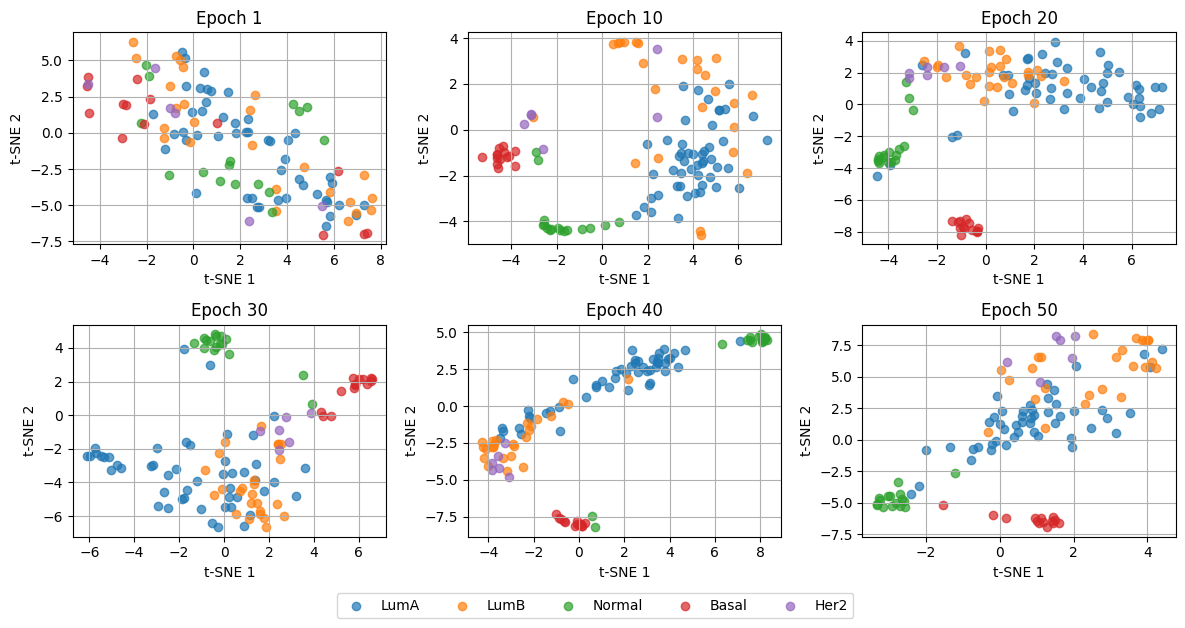

In [19]:
plot_tsne(tsne_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/tsne_results_{0}.pkl".format(model_no), epochs=[1, 10, 20, 30, 40, 50], figsize=(4,3))

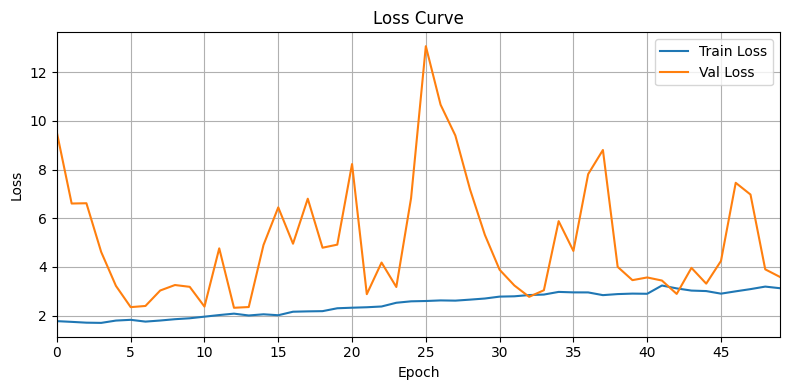

In [20]:
plot_loss(loss_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/loss_history_{0}.json".format(model_no), figsize=(8, 4))

In [21]:
# for name, param in multiomics_model.named_parameters():
#     print(name, param.grad is not None)

In [22]:
model_no=1
loss_fn = RNASeqLoss(
    beta=0.1,               # Target KL weight
    annealing_steps=5000,   # Total steps to anneal over
    use_focal=True,
    focal_gamma=1,
    label_smoothing=0.1,
    class_weights=torch.tensor([1.0, 2.5, 1.0, 1.0, 1.5], device=device) # or torch.tensor([...], device="cuda")
)


rna_exp_dim = 13054
latent_dim = 32
num_classes = 5

# Instantiate model
singleomics_model = SingleOmicsClassifier(
    rna_exp_dim=rna_exp_dim,
    latent_dim=latent_dim,
    num_classes=num_classes
)



loss_callback = LossRecorderCallback(save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/loss_history_{0}.json".format(model_no))
tsne_callback = TSNERecorderCallback(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device=device,
    save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/tsne_results_{0}.pkl".format(model_no)  # Matches your plot_tsne() default
)

trainer_cb = CallbackTrainer(
    model=singleomics_model,
    optimizer=torch.optim.Adam(singleomics_model.parameters(), lr=2e-4),
    loss_fn=loss_fn,
    device=device,
    callbacks=[loss_callback, tsne_callback],
    seed=42
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)

/content/drive/MyDrive/final_project/losses/focal.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('weight', torch.tensor(weight) if weight is not None else None)



Epoch 1/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.72it/s, loss=1.67]


Train Loss: 1.8193


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

Val Loss:   5.7431



Epoch 2/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.97it/s, loss=1.42]


step    10 | loss: 1.6409 | ce: 1.4495 | kl: 25.0220 | beta: 0.0076
Train Loss: 1.6491


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

Val Loss:   3.8010



Epoch 3/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.47it/s, loss=1.35]


Train Loss: 1.5393


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.14it/s]

Val Loss:   2.8277



Epoch 4/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.17it/s, loss=1.72]


Train Loss: 1.5223


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

Val Loss:   2.2939



Epoch 5/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.03it/s, loss=1.9]


step    30 | loss: 1.3235 | ce: 0.9872 | kl: 43.1582 | beta: 0.0078
Train Loss: 1.4917


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

Val Loss:   1.7977



Epoch 6/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.71it/s, loss=1.23]


step    40 | loss: 1.2330 | ce: 0.8059 | kl: 54.3214 | beta: 0.0079
Train Loss: 1.3295


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

Val Loss:   1.6527



Epoch 7/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.01it/s, loss=1.61]


Train Loss: 1.3274


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.21it/s]

Val Loss:   1.3961



Epoch 8/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.25it/s, loss=1.3]

step    50 | loss: 1.2254 | ce: 0.7580 | kl: 58.9043 | beta: 0.0079


Training: 100%|██████████| 5/5 [00:00<00:00,  6.24it/s, loss=1.3]


Train Loss: 1.2161


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

Val Loss:   1.3172



Epoch 9/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  8.40it/s, loss=1.22]


step    60 | loss: 1.1758 | ce: 0.6474 | kl: 65.9690 | beta: 0.0080
Train Loss: 1.1588


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

Val Loss:   1.5685



Epoch 10/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.99it/s, loss=1.19]


Train Loss: 1.1363


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]

Val Loss:   4.8181



Epoch 11/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.45it/s, loss=1.21]


Train Loss: 1.1232


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]

Val Loss:   5.0846



Epoch 12/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.82it/s, loss=1.51]


step    80 | loss: 1.1584 | ce: 0.5323 | kl: 76.7488 | beta: 0.0082
Train Loss: 1.1899


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

Val Loss:   4.6187



Epoch 13/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.76it/s, loss=1.1]


Train Loss: 1.0688


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

Val Loss:   3.3575



Epoch 14/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.41it/s, loss=1.21]


Train Loss: 1.1136


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

Val Loss:   2.2905



Epoch 15/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  20%|██        | 1/5 [00:00<00:01,  2.02it/s, loss=1.15]

step   100 | loss: 1.1190 | ce: 0.4431 | kl: 81.3343 | beta: 0.0083


Training: 100%|██████████| 5/5 [00:00<00:00,  6.64it/s, loss=1.15]


Train Loss: 1.1278


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

Val Loss:   1.9201



Epoch 16/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  8.56it/s, loss=1.14]


step   110 | loss: 1.1427 | ce: 0.3579 | kl: 93.5809 | beta: 0.0084
Train Loss: 1.1327


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

Val Loss:   2.3219



Epoch 17/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.69it/s, loss=1.06]


Train Loss: 1.0963


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.18it/s]

Val Loss:   2.3562



Epoch 18/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.12it/s, loss=1.1]


step   120 | loss: 1.0792 | ce: 0.3091 | kl: 90.9973 | beta: 0.0085
Train Loss: 1.1028


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

Val Loss:   2.4958



Epoch 19/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.11it/s, loss=3.24]


step   130 | loss: 1.1484 | ce: 0.3049 | kl: 98.7515 | beta: 0.0085
Train Loss: 1.5507


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

Val Loss:   1.7017



Epoch 20/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.52it/s, loss=2.1]


Train Loss: 1.3658


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

Val Loss:   2.5971



Epoch 21/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.68it/s, loss=1.14]


Train Loss: 1.1854


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.91it/s]

Val Loss:   4.3193



Epoch 22/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.88it/s, loss=1.98]


step   150 | loss: 1.1104 | ce: 0.3688 | kl: 85.2548 | beta: 0.0087
Train Loss: 1.2904


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]

Val Loss:   2.2577



Epoch 23/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  7.13it/s, loss=1.08]


Train Loss: 1.1306


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

Val Loss:   4.3848



Epoch 24/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.02it/s, loss=1.11]


Train Loss: 1.1495


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

Val Loss:   4.0941



Epoch 25/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.23it/s, loss=1.15]


step   170 | loss: 1.1513 | ce: 0.2818 | kl: 98.1567 | beta: 0.0089
Train Loss: 1.1462


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

Val Loss:   1.9100



Epoch 26/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.39it/s, loss=1.54]


step   180 | loss: 1.5404 | ce: 0.6928 | kl: 94.8173 | beta: 0.0089
Train Loss: 1.2438


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

Val Loss:   1.8192



Epoch 27/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.60it/s, loss=1.11]


Train Loss: 1.1688


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

Val Loss:   1.5902



Epoch 28/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 16.52it/s, loss=1.1]

step   190 | loss: 1.2065 | ce: 0.2742 | kl: 103.3393 | beta: 0.0090


Training: 100%|██████████| 5/5 [00:00<00:00, 10.09it/s, loss=1.1]


Train Loss: 1.1752


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.73it/s]

Val Loss:   1.6105



Epoch 29/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.38it/s, loss=1.35]


step   200 | loss: 1.2155 | ce: 0.2739 | kl: 103.4282 | beta: 0.0091
Train Loss: 1.2250


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

Val Loss:   1.5636



Epoch 30/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.84it/s, loss=1.68]


Train Loss: 1.3525


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.50it/s]

Val Loss:   2.1032



Epoch 31/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.34it/s, loss=2.59]


Train Loss: 1.5601


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

Val Loss:   4.3977



Epoch 32/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.73it/s, loss=1.28]


step   220 | loss: 1.2738 | ce: 0.2705 | kl: 108.2227 | beta: 0.0093
Train Loss: 1.3014


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.65it/s]

Val Loss:   3.4840



Epoch 33/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.08it/s, loss=1.15]


Train Loss: 1.2585


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

Val Loss:   2.3513



Epoch 34/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.61it/s, loss=1.5]


Train Loss: 1.3364


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

Val Loss:   1.6942



Epoch 35/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.49it/s, loss=1.56]


step   240 | loss: 1.2863 | ce: 0.2494 | kl: 109.8413 | beta: 0.0094
Train Loss: 1.3602


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

Val Loss:   1.6148



Epoch 36/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.14it/s, loss=1.55]


step   250 | loss: 1.5520 | ce: 0.4758 | kl: 112.9804 | beta: 0.0095
Train Loss: 1.3318


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.90it/s]

Val Loss:   2.9954



Epoch 37/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.69it/s, loss=1.37]


Train Loss: 1.3291


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.52it/s]

Val Loss:   2.3651



Epoch 38/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.92it/s, loss=1.43]

step   260 | loss: 1.3891 | ce: 0.2821 | kl: 115.1677 | beta: 0.0096


Training: 100%|██████████| 5/5 [00:00<00:00,  6.75it/s, loss=1.43]


Train Loss: 1.3914


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.49it/s]

Val Loss:   2.3152



Epoch 39/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.69it/s, loss=1.68]


step   270 | loss: 1.3617 | ce: 0.2837 | kl: 111.1255 | beta: 0.0097
Train Loss: 1.4614


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

Val Loss:   2.0848



Epoch 40/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.36it/s, loss=1.58]


Train Loss: 1.4507


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]

Val Loss:   1.7733



Epoch 41/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.70it/s, loss=1.4]


Train Loss: 1.4289


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.63it/s]

Val Loss:   3.0082



Epoch 42/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.89it/s, loss=2.78]


step   290 | loss: 1.4738 | ce: 0.2531 | kl: 123.5894 | beta: 0.0099
Train Loss: 1.7032


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.74it/s]

Val Loss:   5.4508



Epoch 43/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.49it/s, loss=2.07]


Train Loss: 1.6903


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

Val Loss:   9.8991



Epoch 44/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.14it/s, loss=2.15]


Train Loss: 1.7267


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Val Loss:   6.3097



Epoch 45/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  20%|██        | 1/5 [00:00<00:01,  2.15it/s, loss=1.81]

step   310 | loss: 1.4917 | ce: 0.2988 | kl: 118.6233 | beta: 0.0101


Training: 100%|██████████| 5/5 [00:00<00:00,  7.03it/s, loss=1.81]


Train Loss: 1.5386


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]

Val Loss:   3.4389



Epoch 46/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.35it/s, loss=1.31]


step   320 | loss: 1.3069 | ce: 0.2562 | kl: 103.5551 | beta: 0.0101
Train Loss: 1.3613


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.87it/s]

Val Loss:   2.0770



Epoch 47/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.55it/s, loss=1.33]


Train Loss: 1.4288


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

Val Loss:   1.8570



Epoch 48/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.53it/s, loss=1.54]


step   330 | loss: 1.3836 | ce: 0.2839 | kl: 107.4048 | beta: 0.0102
Train Loss: 1.4572


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]

Val Loss:   1.8032



Epoch 49/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.34it/s, loss=1.54]


step   340 | loss: 1.4780 | ce: 0.2630 | kl: 117.6109 | beta: 0.0103
Train Loss: 1.4801


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.78it/s]

Val Loss:   2.1414



Epoch 50/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.65it/s, loss=1.33]


Train Loss: 1.4531


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

Val Loss:   1.9554


In [23]:
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Test Accuracy: 0.8030
              precision    recall  f1-score   support

           0       0.96      0.76      0.85        29
           1       0.54      0.93      0.68        15
           2       1.00      1.00      1.00         9
           3       1.00      0.67      0.80         9
           4       1.00      0.50      0.67         4

    accuracy                           0.80        66
   macro avg       0.90      0.77      0.80        66
weighted avg       0.88      0.80      0.81        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "RNASeqLoss",
        "beta": 0.1,
        "use_focal": true,
        "focal_gamma": 1,
        "label_smoothing": 0.1,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "Adam",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0
    }
}


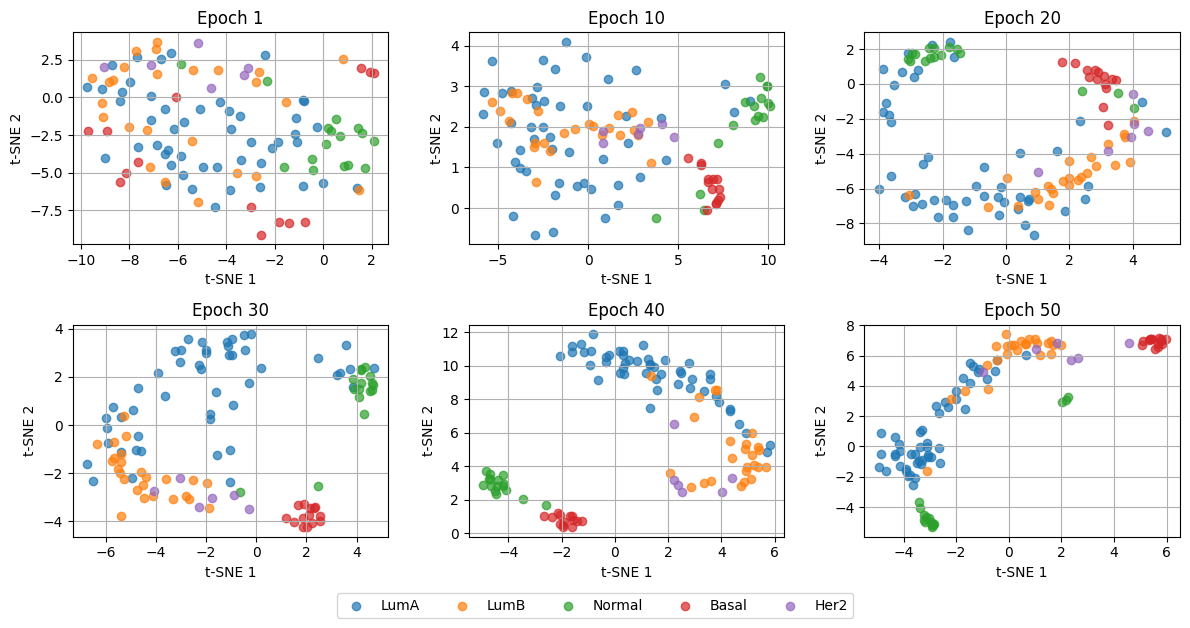

In [24]:
plot_tsne(tsne_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/tsne_results_{0}.pkl".format(model_no), epochs=[1, 10, 20, 30, 40, 50], cols=3, figsize=(4, 3))

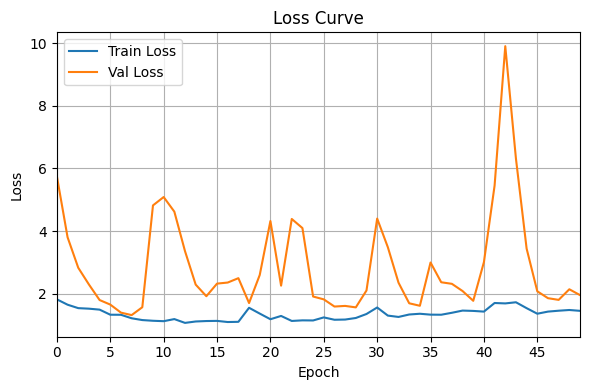

In [25]:
plot_loss(loss_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/loss_history_{0}.json".format(model_no), figsize=(6, 4))

In [26]:
model_no=2
loss_fn = RNASeqLoss(
    beta=0.25,               # Target KL weight
    # annealing_steps=5000,   # Total steps to anneal over
    use_focal=True,
    focal_gamma=2.5,
    label_smoothing=0,
    class_weights=torch.tensor([1.0, 1.0, 1.0, 1.5, 2.5], device=device) # or torch.tensor([...], device="cuda")
)

rna_exp_dim = 13054
latent_dim = 32
num_classes = 5

# Instantiate model
singleomics_model = SingleOmicsClassifier(
    rna_exp_dim=rna_exp_dim,
    latent_dim=latent_dim,
    num_classes=num_classes
)




loss_callback = LossRecorderCallback(save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/loss_history_{0}.json".format(model_no))
acc_callback = AccuracyRecorderCallback(save_path=Path(GOOGLE_DRIVE_PATH + "/logs/rna_seq/accuracy_history_{0}.json".format(model_no)))

tsne_callback = TSNERecorderCallback(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device=device,
    save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/tsne_results_{0}.pkl".format(model_no)  # Matches your plot_tsne() default
)



trainer_cb = CallbackTrainer(
    model=singleomics_model,
    optimizer=torch.optim.AdamW(singleomics_model.parameters(), lr=2e-4, weight_decay=0.0001),
    loss_fn=loss_fn,
    device=device,
    callbacks=[loss_callback, tsne_callback, acc_callback],
    seed=42
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)

/content/drive/MyDrive/final_project/losses/focal.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('weight', torch.tensor(weight) if weight is not None else None)



Epoch 1/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.73it/s, loss=1.16]


Train Loss: 1.2971


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

Val Loss:   15.7179



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4909

Epoch 2/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.61it/s, loss=1.08]


step    10 | loss: 1.3571 | ce: 0.8490 | kl: 26.6811 | beta: 0.0190
Train Loss: 1.2502


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s]

Val Loss:   4.8161



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4909

Epoch 3/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.83it/s, loss=1.45]


Train Loss: 1.3152


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

Val Loss:   3.3843



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5182

Epoch 4/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.08it/s, loss=1.68]


Train Loss: 1.3566


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

Val Loss:   2.6786



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6182

Epoch 5/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.14it/s, loss=1.1]


step    30 | loss: 1.2920 | ce: 0.4844 | kl: 42.0177 | beta: 0.0192
Train Loss: 1.2520


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.57it/s]

Val Loss:   2.7697



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7909

Epoch 6/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.69it/s, loss=1.28]


step    40 | loss: 1.2755 | ce: 0.4252 | kl: 44.0326 | beta: 0.0193
Train Loss: 1.3015


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]

Val Loss:   2.6418



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7091

Epoch 7/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.43it/s, loss=1]


Train Loss: 1.2285


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

Val Loss:   2.0236



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7273

Epoch 8/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  20%|██        | 1/5 [00:00<00:01,  3.47it/s, loss=1.55]

step    50 | loss: 1.2188 | ce: 0.2358 | kl: 50.6715 | beta: 0.0194


Training: 100%|██████████| 5/5 [00:00<00:00, 10.10it/s, loss=1.55]


Train Loss: 1.3457


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

Val Loss:   2.1743



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6273

Epoch 9/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.44it/s, loss=1.12]


step    60 | loss: 1.3217 | ce: 0.1710 | kl: 59.0457 | beta: 0.0195
Train Loss: 1.2960


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

Val Loss:   2.9705



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4909

Epoch 10/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.32it/s, loss=1.28]


Train Loss: 1.3589


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

Val Loss:   5.2907



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.3091

Epoch 11/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.45it/s, loss=1.27]


Train Loss: 1.3967


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

Val Loss:   2.8132



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6727

Epoch 12/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.13it/s, loss=1.41]


step    80 | loss: 1.3966 | ce: 0.1101 | kl: 65.4095 | beta: 0.0197
Train Loss: 1.4556


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

Val Loss:   3.4063



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6091

Epoch 13/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  7.15it/s, loss=1.45]


Train Loss: 1.4317


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.83it/s]

Val Loss:   2.1785



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6909

Epoch 14/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.53it/s, loss=1.72]


Train Loss: 1.5058


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

Val Loss:   1.5842



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8364

Epoch 15/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.44it/s, loss=1.18]


step   100 | loss: 1.5230 | ce: 0.1263 | kl: 70.3625 | beta: 0.0199
Train Loss: 1.4058


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

Val Loss:   1.8974



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8182

Epoch 16/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.59it/s, loss=1.45]


step   110 | loss: 1.4483 | ce: 0.0351 | kl: 70.8648 | beta: 0.0199
Train Loss: 1.4512


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.76it/s]

Val Loss:   1.6446



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8182

Epoch 17/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.74it/s, loss=1.5]


Train Loss: 1.4828


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

Val Loss:   1.5643



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8455

Epoch 18/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.64it/s, loss=1.23]


step   120 | loss: 1.6292 | ce: 0.0982 | kl: 76.4222 | beta: 0.0200
Train Loss: 1.4946


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

Val Loss:   1.6604



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8091

Epoch 19/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.52it/s, loss=1.62]


step   130 | loss: 1.6477 | ce: 0.0335 | kl: 80.2039 | beta: 0.0201
Train Loss: 1.6236


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

Val Loss:   1.6392



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8455

Epoch 20/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.69it/s, loss=1.62]


Train Loss: 1.6675


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

Val Loss:   1.9882



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8091

Epoch 21/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.51it/s, loss=1.7]


Train Loss: 1.7149


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

Val Loss:   3.9807



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6273

Epoch 22/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.73it/s, loss=1.67]


step   150 | loss: 1.7279 | ce: 0.0605 | kl: 82.0880 | beta: 0.0203
Train Loss: 1.7435


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

Val Loss:   7.2934



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5091

Epoch 23/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.58it/s, loss=1.93]


Train Loss: 1.7633


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

Val Loss:   2.0877



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7455

Epoch 24/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.23it/s, loss=1.86]


Train Loss: 1.7473


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

Val Loss:   2.3487



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6545

Epoch 25/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  20%|██        | 1/5 [00:00<00:01,  2.05it/s, loss=1.81]

step   170 | loss: 1.7681 | ce: 0.0280 | kl: 84.8854 | beta: 0.0205


Training: 100%|██████████| 5/5 [00:00<00:00,  6.69it/s, loss=1.81]


Train Loss: 1.7449


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

Val Loss:   1.9144



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8818

Epoch 26/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.71it/s, loss=1.83]


step   180 | loss: 1.8323 | ce: 0.0350 | kl: 87.2753 | beta: 0.0206
Train Loss: 1.7898


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

Val Loss:   1.8470



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8818

Epoch 27/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.49it/s, loss=1.52]


Train Loss: 1.7109


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.77it/s]

Val Loss:   1.9171



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8364

Epoch 28/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.43it/s, loss=1.28]


step   190 | loss: 1.8192 | ce: 0.0289 | kl: 86.5350 | beta: 0.0207
Train Loss: 1.6910


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

Val Loss:   2.0425



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8091

Epoch 29/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.73it/s, loss=2.06]


step   200 | loss: 1.9392 | ce: 0.0213 | kl: 92.2824 | beta: 0.0208
Train Loss: 1.8815


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.67it/s]

Val Loss:   2.1555



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8364

Epoch 30/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.50it/s, loss=1.25]


Train Loss: 1.7577


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.48it/s]

Val Loss:   2.2264



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7818

Epoch 31/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.45it/s, loss=1.88]


Train Loss: 1.8737


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.62it/s]

Val Loss:   2.3333



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7727

Epoch 32/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.54it/s, loss=2.43]


step   220 | loss: 2.0568 | ce: 0.0997 | kl: 93.3086 | beta: 0.0210
Train Loss: 2.0440


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

Val Loss:   11.5870



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.2364

Epoch 33/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.69it/s, loss=1.56]


Train Loss: 1.9011


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

Val Loss:   12.5314



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.2545

Epoch 34/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.70it/s, loss=1.71]


Train Loss: 1.8996


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

Val Loss:   5.4744



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4364

Epoch 35/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.02it/s, loss=1.99]


step   240 | loss: 1.8647 | ce: 0.0359 | kl: 86.3950 | beta: 0.0212
Train Loss: 1.9472


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

Val Loss:   3.1026



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5091

Epoch 36/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 11.06it/s, loss=1.86]


step   250 | loss: 1.8556 | ce: 0.0096 | kl: 86.8099 | beta: 0.0213
Train Loss: 1.9599


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

Val Loss:   1.9956



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6455

Epoch 37/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.88it/s, loss=2.03]


Train Loss: 2.0112


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

Val Loss:   1.9516



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6818

Epoch 38/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.61it/s, loss=1.89]


step   260 | loss: 2.0871 | ce: 0.0135 | kl: 97.0664 | beta: 0.0214
Train Loss: 2.0071


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

Val Loss:   1.8974



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6636

Epoch 39/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.60it/s, loss=2.13]


step   270 | loss: 2.0179 | ce: 0.0227 | kl: 92.9691 | beta: 0.0215
Train Loss: 2.0782


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]

Val Loss:   1.8460



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7364

Epoch 40/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.24it/s, loss=1.63]


Train Loss: 2.0219


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.86it/s]

Val Loss:   1.8978



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8364

Epoch 41/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.18it/s, loss=1.61]


Train Loss: 2.0110


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

Val Loss:   2.7791



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6818

Epoch 42/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.50it/s, loss=2.22]


step   290 | loss: 2.0150 | ce: 0.1085 | kl: 88.0314 | beta: 0.0217
Train Loss: 2.0474


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

Val Loss:   3.4122



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6182

Epoch 43/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.75it/s, loss=1.74]


Train Loss: 1.8699


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

Val Loss:   8.0905



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4909

Epoch 44/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.15it/s, loss=2.03]


Train Loss: 1.9925


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

Val Loss:   5.4015



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6727

Epoch 45/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.07it/s, loss=1.95]


step   310 | loss: 2.1077 | ce: 0.0239 | kl: 95.3444 | beta: 0.0219
Train Loss: 2.0770


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

Val Loss:   4.1850



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7091

Epoch 46/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.45it/s, loss=2.18]


step   320 | loss: 2.1766 | ce: 0.0065 | kl: 98.8358 | beta: 0.0220
Train Loss: 2.1657


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.82it/s]

Val Loss:   2.2621



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7455

Epoch 47/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.43it/s, loss=2.76]


Train Loss: 2.2535


Validation: 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

Val Loss:   2.3995



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7909

Epoch 48/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.09it/s, loss=2.62]


step   330 | loss: 2.2920 | ce: 0.0281 | kl: 102.6447 | beta: 0.0221
Train Loss: 2.3176


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.79it/s]

Val Loss:   7.4380



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5545

Epoch 49/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s, loss=3.1]


step   340 | loss: 2.4388 | ce: 0.0411 | kl: 108.2141 | beta: 0.0222
Train Loss: 2.4767


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

Val Loss:   3.8432



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6727

Epoch 50/50


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.93it/s, loss=2.09]


Train Loss: 2.3081


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

Val Loss:   3.3372



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7364


In [27]:
from utils import set_seed
set_seed(42)
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Test Accuracy: 0.7121
              precision    recall  f1-score   support

           0       0.74      0.90      0.81        29
           1       0.71      0.33      0.45        15
           2       0.82      1.00      0.90         9
           3       1.00      0.33      0.50         9
           4       0.40      1.00      0.57         4

    accuracy                           0.71        66
   macro avg       0.74      0.71      0.65        66
weighted avg       0.76      0.71      0.69        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "RNASeqLoss",
        "beta": 0.25,
        "use_focal": true,
        "focal_gamma": 2.5,
        "label_smoothing": 0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "AdamW",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0.0001
    }
}


In [28]:
import numpy as np
from sklearn.metrics import accuracy_score
from utils import set_seed
import torch

def evaluate_multiple_seeds(trainer, test_loader, seeds=100):
    accs = []

    for seed in np.random.randint(0, 10_000, size=seeds):
        set_seed(int(seed))  # Reset seed
        preds, targets = trainer.predict(test_loader)
        acc = accuracy_score(targets.numpy(), preds.numpy())
        accs.append(acc)

    accs = np.array(accs)
    print(f"\n✅ Avg Accuracy over {seeds} seeds: {accs.mean():.4f} ± {accs.std():.4f}")
    return accs
accs = evaluate_multiple_seeds(trainer_cb, dataloaders["test"], seeds=100)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T


✅ Avg Accuracy over 100 seeds: 0.6935 ± 0.0142


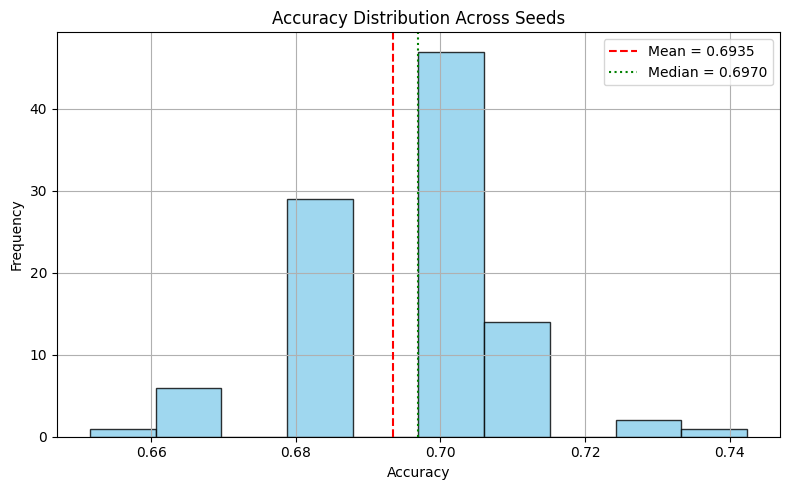

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy_distribution(accs, bins=10, title="Accuracy Distribution Across Seeds"):
    plt.figure(figsize=(8, 5))
    plt.hist(accs, bins=bins, color="skyblue", edgecolor="black", alpha=0.8)
    plt.axvline(np.mean(accs), color='red', linestyle='--', label=f"Mean = {np.mean(accs):.4f}")
    plt.axvline(np.median(accs), color='green', linestyle=':', label=f"Median = {np.median(accs):.4f}")

    plt.title(title)
    plt.xlabel("Accuracy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_accuracy_distribution(accs)

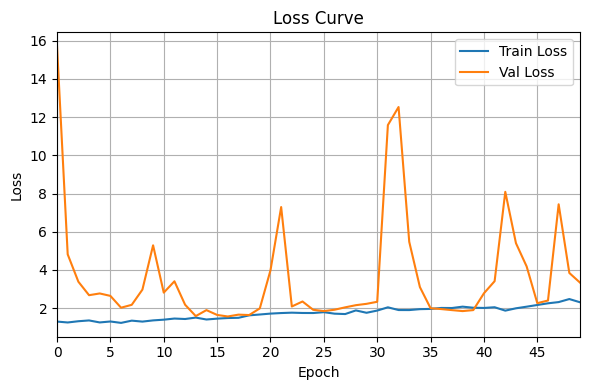

In [30]:
plot_loss(loss_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/loss_history_{0}.json".format(model_no), figsize=(6, 4))

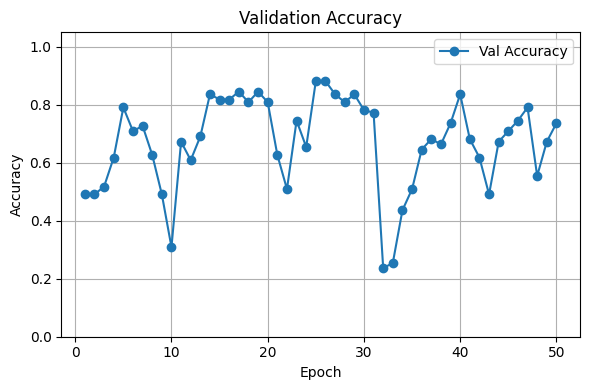

In [31]:
from utils import plot_accuracy
plot_accuracy(GOOGLE_DRIVE_PATH + "/logs/rna_seq/accuracy_history_{0}.json".format(model_no), figsize=(6, 4))

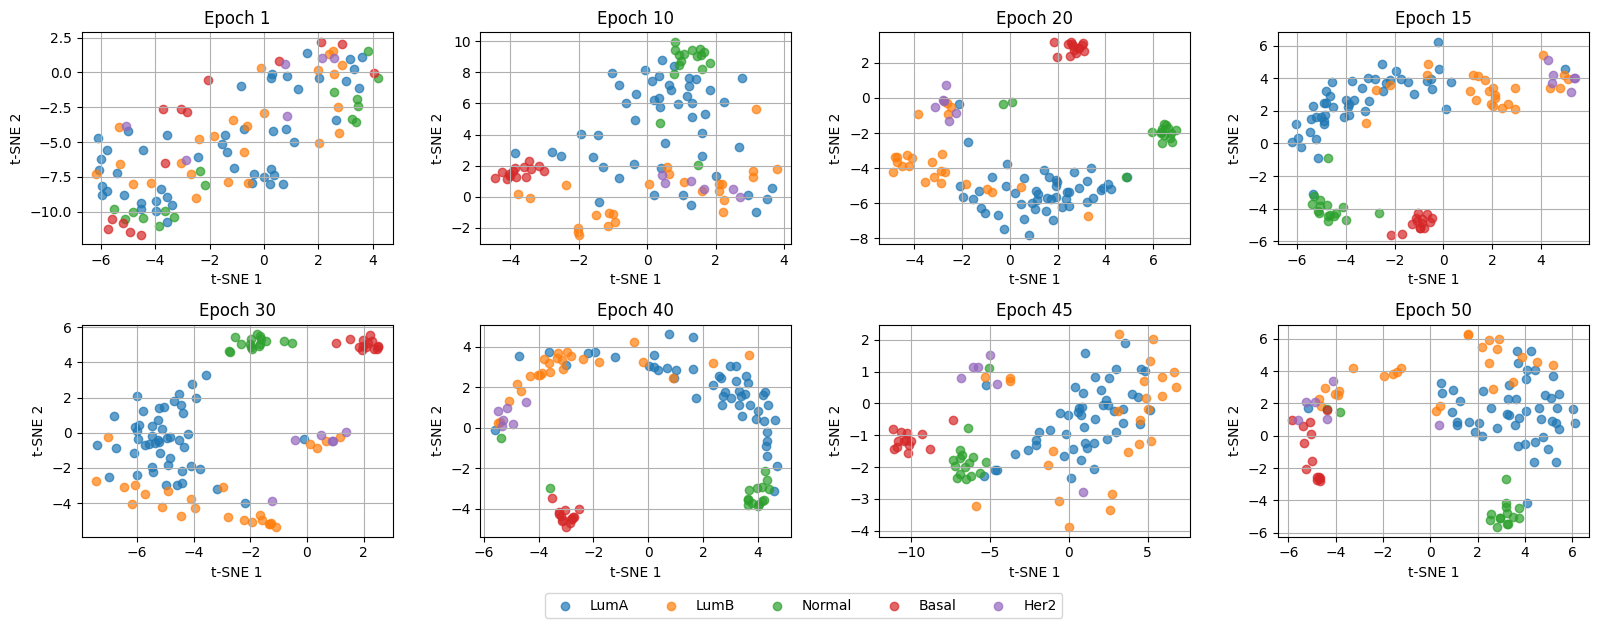

In [32]:
plot_tsne(tsne_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/tsne_results_{0}.pkl".format(model_no), epochs=[1, 10, 20, 15, 30, 40, 45, 50], cols=4, figsize=(4, 3))

In [33]:
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Test Accuracy: 0.7273
              precision    recall  f1-score   support

           0       0.73      0.93      0.82        29
           1       0.80      0.27      0.40        15
           2       0.82      1.00      0.90         9
           3       1.00      0.44      0.62         9
           4       0.44      1.00      0.62         4

    accuracy                           0.73        66
   macro avg       0.76      0.73      0.67        66
weighted avg       0.78      0.73      0.69        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "RNASeqLoss",
        "beta": 0.25,
        "use_focal": true,
        "focal_gamma": 2.5,
        "label_smoothing": 0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "AdamW",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0.0001
    }
}


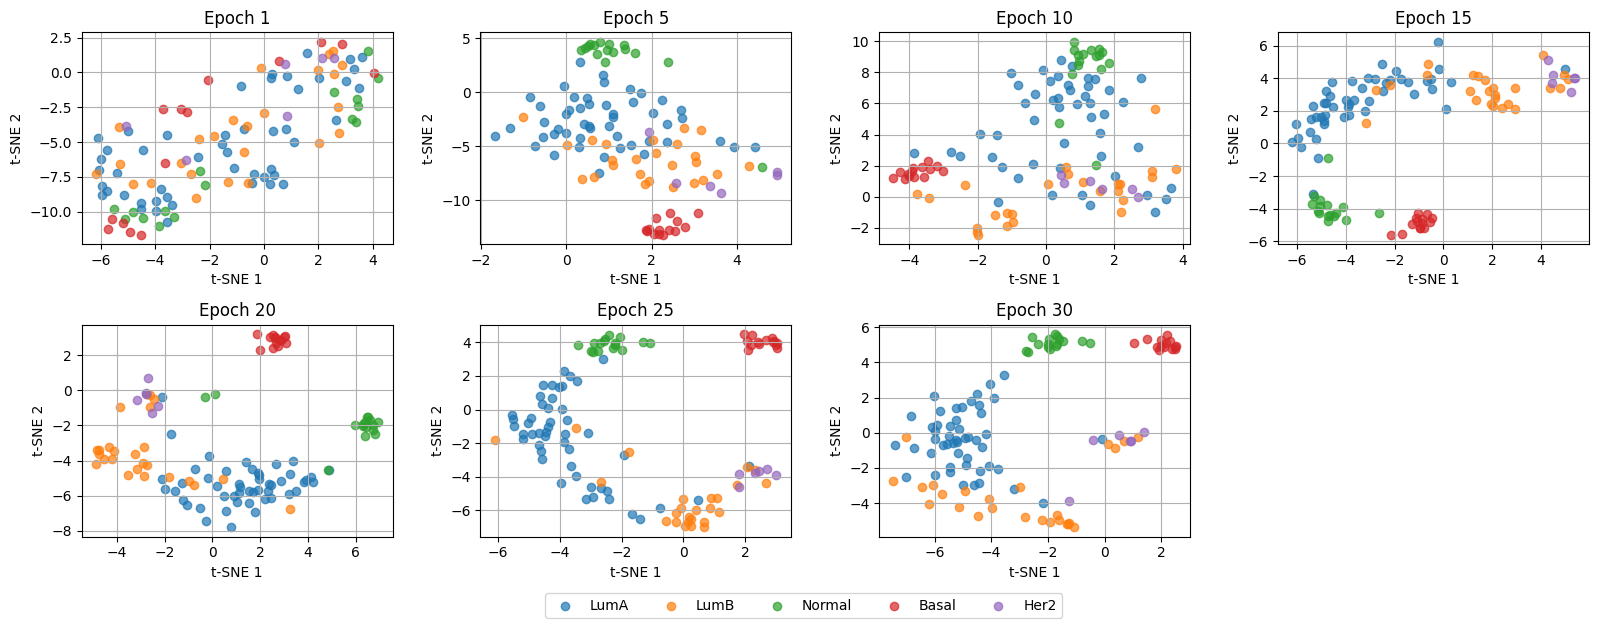

In [34]:
plot_tsne(tsne_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/tsne_results_{0}.pkl".format(model_no), epochs=[1, 5, 10, 15, 20, 25, 30], cols=4, figsize=(4, 3))

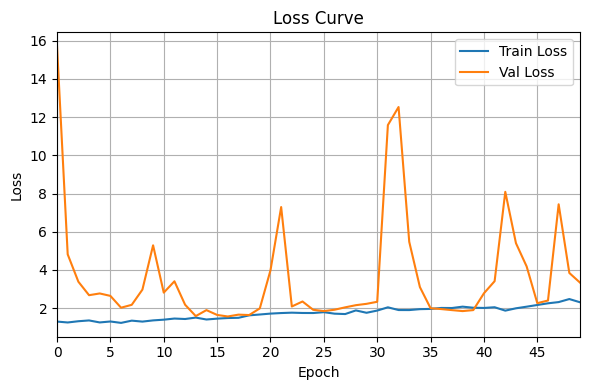

In [35]:
plot_loss(loss_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/loss_history_{0}.json".format(model_no), figsize=(6, 4))

In [36]:
preds, targets, logits = trainer_cb.predict(dataloaders["test"], return_logits=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [37]:
import torch.nn.functional as F
probs = F.softmax(logits, dim=1)
predictions = torch.argmax(probs, dim=1)

predictions

tensor([0, 1, 0, 0, 0, 2, 4, 0, 1, 4, 3, 1, 0, 1, 0, 2, 0, 0, 4, 0, 0, 4, 4, 4,
        0, 0, 0, 0, 0, 4, 0, 2, 3, 0, 0, 0, 2, 1, 0, 0, 0, 3, 2, 0, 0, 2, 2, 0,
        2, 0, 2, 0, 0, 1, 4, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2])

In [38]:
model_no = 3
loss_fn = RNASeqLoss(
    beta=0.1,               # Target KL weight
    # annealing_steps=5000,   # Total steps to anneal over
    use_focal=True,
    focal_gamma=2.5,
    label_smoothing=0,
    class_weights=torch.tensor([1.0, 1.0, 1.0, 1.5, 2.5], device=device) # or torch.tensor([...], device="cuda")
)

rna_exp_dim = 13054
latent_dim = 64
num_classes = 5

# Instantiate model
singleomics_model = SingleOmicsClassifier(
    rna_exp_dim=rna_exp_dim,
    latent_dim=latent_dim,
    num_classes=num_classes
)




loss_callback = LossRecorderCallback(save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/loss_history_{0}.json".format(model_no))
acc_callback = AccuracyRecorderCallback(save_path=Path(GOOGLE_DRIVE_PATH + "/logs/rna_seq/accuracy_history_{0}.json".format(model_no)))
tsne_callback = TSNERecorderCallback(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device=device,
    save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/tsne_results_{0}.pkl".format(model_no)  # Matches your plot_tsne() default
)
attn_cb = AttentionLoggerCallback(save_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/attention_weights_{0}.pkl".format(model_no), modality_names=["rna"])




trainer_cb = CallbackTrainer(
    model=singleomics_model,
    optimizer=torch.optim.AdamW(singleomics_model.parameters(), lr=5e-4, weight_decay=1e-4),
    loss_fn=loss_fn,
    device=device,
    callbacks=[loss_callback, tsne_callback, acc_callback, attn_cb],
    seed=42
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=60)

/content/drive/MyDrive/final_project/losses/focal.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('weight', torch.tensor(weight) if weight is not None else None)



Epoch 1/60


Training: 100%|██████████| 5/5 [00:00<00:00,  9.60it/s, loss=0.815]


Train Loss: 1.1640


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

Val Loss:   27.9510



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4455

Epoch 2/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.80it/s, loss=0.768]


step    10 | loss: 1.0572 | ce: 0.6273 | kl: 56.4389 | beta: 0.0076
Train Loss: 0.9315


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

Val Loss:   7.3136



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4727

Epoch 3/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s, loss=0.941]


Train Loss: 0.9509


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

Val Loss:   2.4137



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7818

Epoch 4/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.82it/s, loss=1.21]


Train Loss: 0.9865


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

Val Loss:   2.1040



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5545

Epoch 5/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.57it/s, loss=0.973]


step    30 | loss: 1.0239 | ce: 0.1602 | kl: 112.3367 | beta: 0.0077
Train Loss: 1.0353


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

Val Loss:   3.8656



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.3182
🚩 End of epoch 5 — Logging attention

Epoch 6/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.90it/s, loss=1.22]


step    40 | loss: 1.2247 | ce: 0.3435 | kl: 114.0873 | beta: 0.0077
Train Loss: 1.0591


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

Val Loss:   2.4534



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5545

Epoch 7/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.96it/s, loss=0.791]


Train Loss: 1.0174


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.12it/s]

Val Loss:   2.7859



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4091

Epoch 8/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  20%|██        | 1/5 [00:00<00:01,  3.27it/s, loss=1.24]

step    50 | loss: 1.0768 | ce: 0.1194 | kl: 123.3758 | beta: 0.0078


Training: 100%|██████████| 5/5 [00:00<00:00,  9.80it/s, loss=1.24]


Train Loss: 1.1329


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

Val Loss:   2.8562



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5545

Epoch 9/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.30it/s, loss=1.1]


step    60 | loss: 1.2694 | ce: 0.0682 | kl: 154.0945 | beta: 0.0078
Train Loss: 1.1993


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

Val Loss:   2.1712



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6909

Epoch 10/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.46it/s, loss=1.29]


Train Loss: 1.2575


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

Val Loss:   2.2608



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6091
🚩 End of epoch 10 — Logging attention

Epoch 11/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.72it/s, loss=1.22]


Train Loss: 1.2850


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

Val Loss:   2.4903



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5273

Epoch 12/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.64it/s, loss=1.36]


step    80 | loss: 1.2918 | ce: 0.0159 | kl: 162.1677 | beta: 0.0079
Train Loss: 1.3246


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

Val Loss:   2.6870



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5182

Epoch 13/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.60it/s, loss=1.33]


Train Loss: 1.3496


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.51it/s]

Val Loss:   1.6535



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7727

Epoch 14/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.46it/s, loss=1.41]


Train Loss: 1.3456


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

Val Loss:   1.8262



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7727

Epoch 15/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  7.21it/s, loss=1.13]


step   100 | loss: 1.4420 | ce: 0.0281 | kl: 178.0727 | beta: 0.0079
Train Loss: 1.3284


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

Val Loss:   2.4292



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7455
🚩 End of epoch 15 — Logging attention

Epoch 16/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.99it/s, loss=1.39]


step   110 | loss: 1.3921 | ce: 0.0094 | kl: 173.3317 | beta: 0.0080
Train Loss: 1.3676


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.33it/s]

Val Loss:   1.5617



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8182

Epoch 17/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.76it/s, loss=1.34]


Train Loss: 1.3685


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

Val Loss:   1.6488



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7545

Epoch 18/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.13it/s, loss=1.35]


step   120 | loss: 1.4657 | ce: 0.0063 | kl: 182.1148 | beta: 0.0080
Train Loss: 1.4042


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

Val Loss:   1.6854



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7273

Epoch 19/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.73it/s, loss=1.26]


step   130 | loss: 1.4391 | ce: 0.0057 | kl: 178.0596 | beta: 0.0081
Train Loss: 1.3883


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

Val Loss:   2.2008



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6273

Epoch 20/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.24it/s, loss=1.46]


Train Loss: 1.4285


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

Val Loss:   1.6828



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8182
🚩 End of epoch 20 — Logging attention

Epoch 21/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.60it/s, loss=2.33]


Train Loss: 1.6447


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

Val Loss:   2.3105



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6727

Epoch 22/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.61it/s, loss=1.37]


step   150 | loss: 1.4645 | ce: 0.0259 | kl: 177.0635 | beta: 0.0081
Train Loss: 1.5165


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

Val Loss:   4.3345



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.3727

Epoch 23/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.77it/s, loss=1.92]


Train Loss: 1.6421


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

Val Loss:   6.2171



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.3364

Epoch 24/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00, 10.14it/s, loss=2.11]


Train Loss: 1.9070


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.14it/s]

Val Loss:   7.9886



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.3091

Epoch 25/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.32it/s, loss=1.65]


step   170 | loss: 1.7603 | ce: 0.0762 | kl: 205.3861 | beta: 0.0082
Train Loss: 1.7590


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

Val Loss:   3.0590



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6636
🚩 End of epoch 25 — Logging attention

Epoch 26/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s, loss=1.81]


step   180 | loss: 1.8061 | ce: 0.0265 | kl: 216.0400 | beta: 0.0082
Train Loss: 1.7799


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.77it/s]

Val Loss:   3.0975



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8000

Epoch 27/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.54it/s, loss=1.64]


Train Loss: 1.7426


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

Val Loss:   3.2683



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8091

Epoch 28/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.80it/s, loss=1.51]


step   190 | loss: 1.8131 | ce: 0.0286 | kl: 215.6412 | beta: 0.0083
Train Loss: 1.7474


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

Val Loss:   3.0598



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8000

Epoch 29/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.65it/s, loss=1.99]


step   200 | loss: 1.8752 | ce: 0.0496 | kl: 219.5895 | beta: 0.0083
Train Loss: 1.8377


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

Val Loss:   2.7551



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8273

Epoch 30/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.48it/s, loss=1.89]


Train Loss: 1.8794


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.90it/s]

Val Loss:   2.9483



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7909
🚩 End of epoch 30 — Logging attention

Epoch 31/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.12it/s, loss=1.65]


Train Loss: 1.8444


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

Val Loss:   2.2094



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8091

Epoch 32/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.43it/s, loss=2.31]


step   220 | loss: 2.1978 | ce: 0.2707 | kl: 229.6964 | beta: 0.0084
Train Loss: 2.0828


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

Val Loss:   4.5970



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5182

Epoch 33/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.56it/s, loss=2.18]


Train Loss: 2.1873


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

Val Loss:   8.2815



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.3091

Epoch 34/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.38it/s, loss=2.29]


Train Loss: 2.2497


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

Val Loss:   12.0917



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5818

Epoch 35/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.11it/s, loss=2.28]


step   240 | loss: 2.3242 | ce: 0.0436 | kl: 269.3430 | beta: 0.0085
Train Loss: 2.3717


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

Val Loss:   3.8128



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6636
🚩 End of epoch 35 — Logging attention

Epoch 36/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  8.89it/s, loss=2.05]


step   250 | loss: 2.0549 | ce: 0.0092 | kl: 240.4947 | beta: 0.0085
Train Loss: 2.2680


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

Val Loss:   2.6002



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7909

Epoch 37/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.49it/s, loss=2.51]


Train Loss: 2.3699


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

Val Loss:   2.3672



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8182

Epoch 38/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.45it/s, loss=2.36]


step   260 | loss: 2.3859 | ce: 0.0109 | kl: 277.9367 | beta: 0.0085
Train Loss: 2.3496


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

Val Loss:   2.4277



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7364

Epoch 39/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.42it/s, loss=2.52]


step   270 | loss: 2.3707 | ce: 0.0210 | kl: 273.7259 | beta: 0.0086
Train Loss: 2.3979


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

Val Loss:   2.3597



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7455

Epoch 40/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.50it/s, loss=1.94]


Train Loss: 2.2798


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

Val Loss:   2.5068



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7727
🚩 End of epoch 40 — Logging attention

Epoch 41/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.38it/s, loss=2.39]


Train Loss: 2.3895


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

Val Loss:   3.4378



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7545

Epoch 42/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  20%|██        | 1/5 [00:00<00:01,  3.08it/s, loss=2.47]

step   290 | loss: 2.3167 | ce: 0.0446 | kl: 262.2781 | beta: 0.0087


Training: 100%|██████████| 5/5 [00:00<00:00,  8.50it/s, loss=2.47]


Train Loss: 2.3663


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

Val Loss:   14.3445



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4636

Epoch 43/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.48it/s, loss=2.09]


Train Loss: 2.3162


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.60it/s]

Val Loss:   12.2667



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5455

Epoch 44/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.48it/s, loss=2.32]


Train Loss: 2.3767


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.06it/s]

Val Loss:   6.6014



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6455

Epoch 45/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.58it/s, loss=2.15]


step   310 | loss: 2.5268 | ce: 0.0121 | kl: 287.6437 | beta: 0.0087
Train Loss: 2.3688


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]

Val Loss:   4.0740



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7818
🚩 End of epoch 45 — Logging attention

Epoch 46/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.52it/s, loss=2.79]


step   320 | loss: 2.7933 | ce: 0.0034 | kl: 317.6729 | beta: 0.0088
Train Loss: 2.4930


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.70it/s]

Val Loss:   3.1041



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8364

Epoch 47/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.28it/s, loss=4.78]


Train Loss: 2.8946


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

Val Loss:   3.4731



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7909

Epoch 48/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  20%|██        | 1/5 [00:00<00:02,  1.88it/s, loss=3.81]

step   330 | loss: 2.4753 | ce: 0.0121 | kl: 279.1931 | beta: 0.0088


Training: 100%|██████████| 5/5 [00:00<00:00,  5.88it/s, loss=3.81]


Train Loss: 2.7547


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

Val Loss:   5.1768



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.5818

Epoch 49/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.14it/s, loss=3.87]


step   340 | loss: 2.8755 | ce: 0.1734 | kl: 304.8856 | beta: 0.0089
Train Loss: 2.8903


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

Val Loss:   4.2268



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.4182

Epoch 50/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.23it/s, loss=2.9]


Train Loss: 2.7850


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

Val Loss:   2.4296



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.8545
🚩 End of epoch 50 — Logging attention

Epoch 51/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.26it/s, loss=2.13]


Train Loss: 2.6645


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

Val Loss:   2.2278



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7909

Epoch 52/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.81it/s, loss=2.38]


step   360 | loss: 2.7983 | ce: 0.0758 | kl: 304.3990 | beta: 0.0089
Train Loss: 2.6756


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.13it/s]

Val Loss:   2.7367



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6909

Epoch 53/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.07it/s, loss=2.94]


Train Loss: 2.7827


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

Val Loss:   3.1368



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6273

Epoch 54/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  6.08it/s, loss=2.59]


Train Loss: 2.8532


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

Val Loss:   3.1559



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6455

Epoch 55/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.39it/s, loss=3.02]


step   380 | loss: 2.9885 | ce: 0.0099 | kl: 330.0101 | beta: 0.0090
Train Loss: 3.0052


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

Val Loss:   3.1664



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7273
🚩 End of epoch 55 — Logging attention

Epoch 56/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.00it/s, loss=2.96]


step   390 | loss: 2.9590 | ce: 0.7776 | kl: 240.5966 | beta: 0.0091
Train Loss: 3.0419


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.04it/s]

Val Loss:   4.4698



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.6455

Epoch 57/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.64it/s, loss=3.25]


Train Loss: 3.1262


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

Val Loss:   2.9631



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7909

Epoch 58/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.54it/s, loss=3.08]


step   400 | loss: 3.0054 | ce: 0.0425 | kl: 325.2988 | beta: 0.0091
Train Loss: 3.0413


Validation: 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

Val Loss:   3.0823



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7818

Epoch 59/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:  20%|██        | 1/5 [00:00<00:02,  1.73it/s, loss=3.75]

step   410 | loss: 3.1065 | ce: 0.0470 | kl: 334.3890 | beta: 0.0091


Training: 100%|██████████| 5/5 [00:00<00:00,  5.89it/s, loss=3.75]


Train Loss: 3.3198


Validation: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

Val Loss:   3.6697



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7273

Epoch 60/60


Training:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 5/5 [00:00<00:00,  9.50it/s, loss=3.54]


Train Loss: 3.3412


Validation: 100%|██████████| 2/2 [00:00<00:00,  5.19it/s]

Val Loss:   3.2459



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Val Accuracy: 0.7636
🚩 End of epoch 60 — Logging attention
📦 Saved attention log to: /content/drive/MyDrive/final_project/logs/rna_seq/attention_weights_3.pkl


In [39]:
from utils import set_seed
set_seed(42)
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Test Accuracy: 0.7727
              precision    recall  f1-score   support

           0       0.95      0.72      0.82        29
           1       0.59      0.87      0.70        15
           2       0.82      1.00      0.90         9
           3       1.00      0.56      0.71         9
           4       0.50      0.75      0.60         4

    accuracy                           0.77        66
   macro avg       0.77      0.78      0.75        66
weighted avg       0.83      0.77      0.78        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "RNASeqLoss",
        "beta": 0.1,
        "use_focal": true,
        "focal_gamma": 2.5,
        "label_smoothing": 0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "AdamW",
        "lr": 0.0005,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0.0001
    }
}


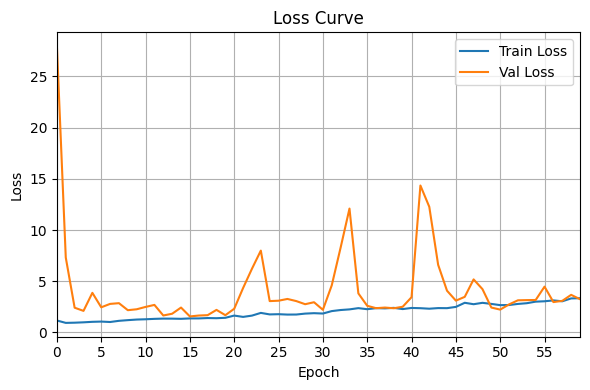

In [40]:
plot_loss(loss_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/loss_history_{0}.json".format(model_no), figsize=(6, 4))

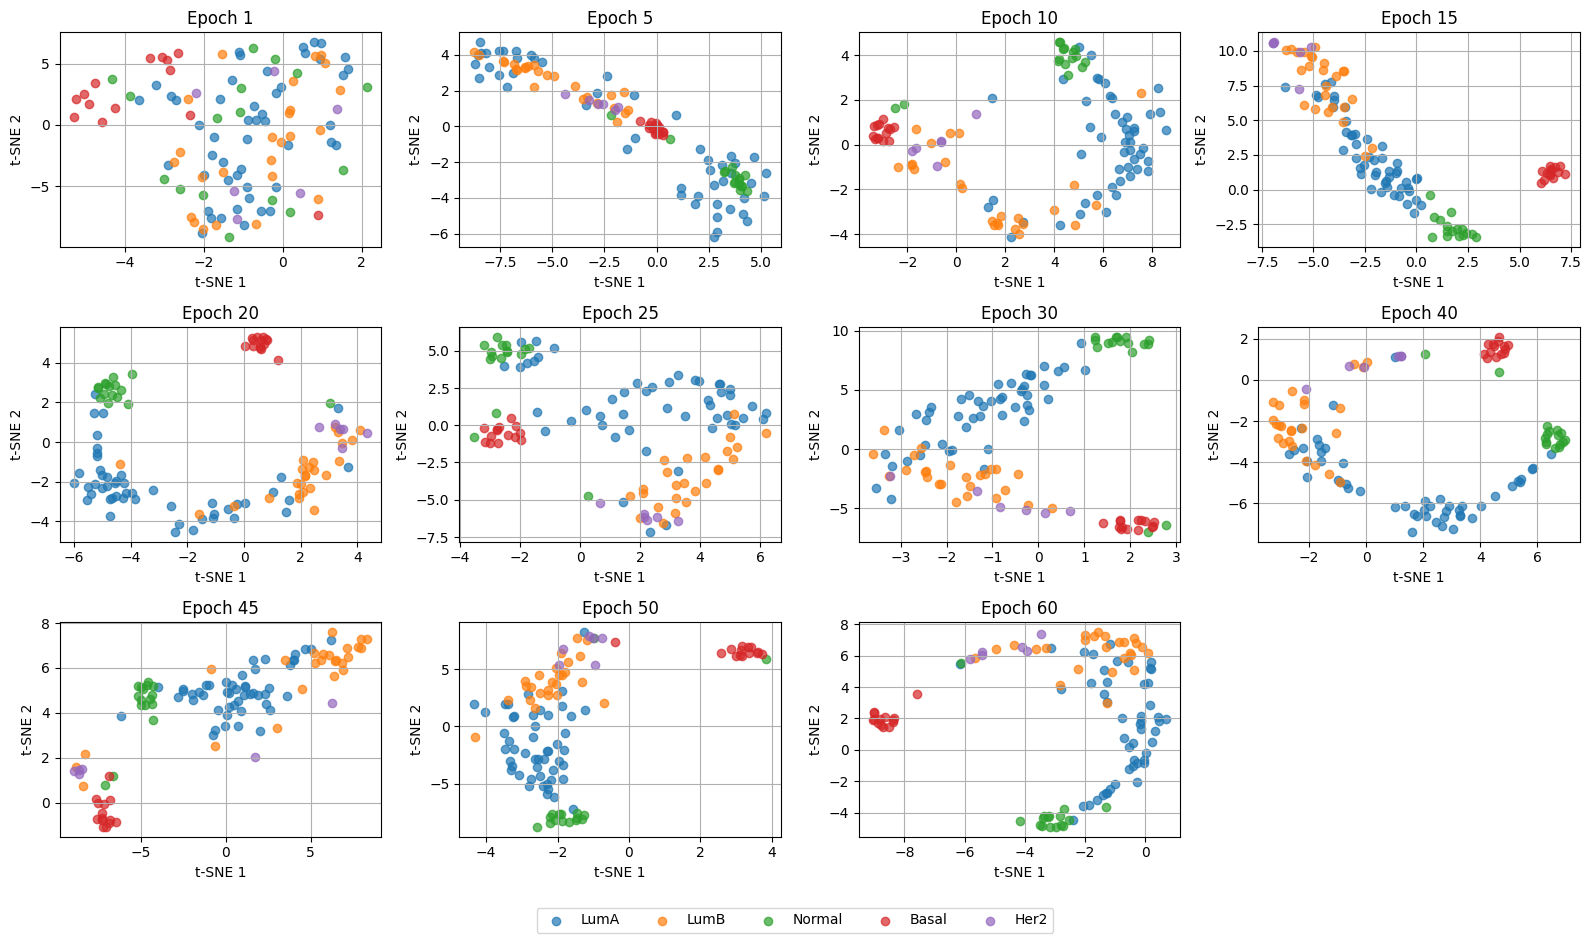

In [41]:
plot_tsne(tsne_path=GOOGLE_DRIVE_PATH + "/logs/rna_seq/tsne_results_{0}.pkl".format(model_no), epochs=[1, 5, 10, 15, 20, 25, 30, 40,45, 50, 60], cols=4, figsize=(4, 3))

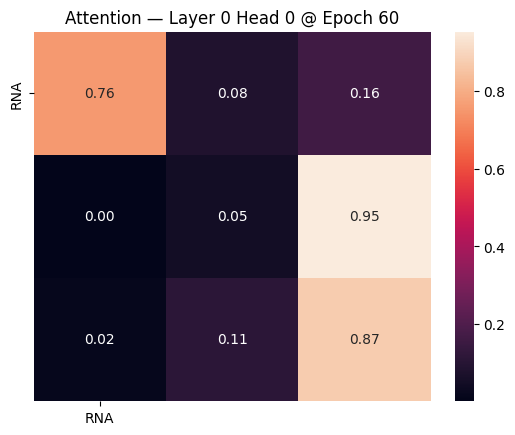

In [42]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

with open(GOOGLE_DRIVE_PATH + "/logs/rna_seq/attention_weights_{0}.pkl".format(model_no), "rb") as f:
    attention_log = pickle.load(f)

# Example: plot head 0 from layer 0 at epoch 50
last_epoch = attention_log[-1]
weights = last_epoch["attn"][0][0]  # layer 0, head 0
labels = ["RNA"]
sns.heatmap(weights, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
plt.title(f"Attention — Layer 0 Head 0 @ Epoch {last_epoch['epoch']}")
plt.show()

In [43]:
#  Inspect file contents

file_npz = GOOGLE_DRIVE_PATH + "/data/clean_data/multimodal_data_features.npz"
with np.load(file_npz, allow_pickle=True) as data:
    print("Available keys:", list(data.keys()))
    print("RNA features shape:", data["rna_features"].shape)

Available keys: ['samples', 'mirna_features', 'rna_features', 'methylation_features', 'class_map', 'metadata']
RNA features shape: (13054,)


In [44]:
# Get gene names and class mapping

with np.load(file_npz, allow_pickle=True) as data:
    gene_names = data["rna_features"]
    class_map = data['class_map']

gene_names, class_map

(array(['?|10357', '?|10431', '?|155060', ..., 'ZZEF1|23140', 'ZZZ3|26009',
        'psiTPTE22|387590'], dtype=object),
 array({'LumA': 0, 'LumB': 1, 'Normal': 2, 'Basal': 3, 'Her2': 4},
       dtype=object))

In [45]:
class_map.item()

{'LumA': 0, 'LumB': 1, 'Normal': 2, 'Basal': 3, 'Her2': 4}

In [46]:
from utils.interpretability import compute_average_saliency_by_class, plot_saliency_radar
import pandas as pd
# 1. Your trained model and test dataloader

singleomics_model.eval()
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
singleomics_model.to(device)

# 2. Compute average saliency for RNA modality
saliency_by_class = compute_average_saliency_by_class(
    model=singleomics_model,
    dataloader=dataloaders['test'],
    modality_key='rna',           # or 'mirna', 'methyl'
    max_per_class=50,
    device=device
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [47]:
id_to_type = {v:k for k, v in class_map.item().items()}
df_saliency_by_class = pd.DataFrame(saliency_by_class, index=gene_names).rename(columns=id_to_type)
df_saliency_by_class

,LumB,LumA,Basal,Normal,Her2
?|10357,0.001299,0.000798,0.001805,0.000108,0.003133
?|10431,0.000241,0.000298,0.000457,0.000077,0.000363
?|155060,0.000980,0.000639,0.001342,0.000123,0.002336
?|57714,0.000326,0.000683,0.000608,0.000252,0.000232
?|653553,0.000757,0.000688,0.001264,0.000374,0.002729
...,...,...,...,...,...
ZYG11B|79699,0.000330,0.000461,0.000711,0.000059,0.000737
ZYX|7791,0.000479,0.000701,0.000574,0.000259,0.001230
ZZEF1|23140,0.000624,0.000831,0.001120,0.000117,0.001280
ZZZ3|26009,0.001123,0.001049,0.001697,0.000117,0.001225


In [48]:
top5_by_class = {cls: df_saliency_by_class[cls].nlargest(5).index.tolist()
                 for cls in df_saliency_by_class.columns}

bottom5_by_class = {cls: df_saliency_by_class[cls].nsmallest(5).index.tolist()
                    for cls in df_saliency_by_class.columns}

In [49]:
top5_by_class

{'LumB': ['RNF39|80352',
  'TRIM25|7706',
  'SNX27|81609',
  'CKS1B|1163',
  'PRDXDD1P|344405'],
 'LumA': ['VSIG10L|147645',
  'TFAP2C|7022',
  'RAB6A|5870',
  'TRIM25|7706',
  'EFNA5|1946'],
 'Basal': ['RNF39|80352',
  'ZNF750|79755',
  'TRIM25|7706',
  'MYBL1|4603',
  'SNX27|81609'],
 'Normal': ['VSIG10L|147645',
  'WWC1|23286',
  'TEAD3|7005',
  'ZNF30|90075',
  'TFAP2C|7022'],
 'Her2': ['SERHL|94009',
  'GRB7|2886',
  'RNF39|80352',
  'ERBB2|2064',
  'C20orf108|116151']}

In [50]:
# Extract top and bottom 5 genes per class
summary_table = []

for cls in df_saliency_by_class.columns:
    top_genes = df_saliency_by_class[cls].nlargest(5).index.tolist()
    bottom_genes = df_saliency_by_class[cls].nsmallest(5).index.tolist()

    top_genes = [g.split("|")[0] for g in top_genes]
    bottom_genes = [g.split("|")[0] for g in bottom_genes]

    summary_table.append({
        "Subtype": cls,
        "Top 5 Genes": ", ".join(top_genes),
        "Bottom 5 Genes": ", ".join(bottom_genes)
    })

df_summary = pd.DataFrame(summary_table)

In [51]:
df_summary

,Subtype,Top 5 Genes,Bottom 5 Genes
0,LumB,"RNF39, TRIM25, SNX27, CKS1B, PRDXDD1P","ATPAF2, TTC12, KIAA2018, KCTD17, DDAH2"
1,LumA,"VSIG10L, TFAP2C, RAB6A, TRIM25, EFNA5","DDAH2, LRPAP1, FBXO22OS, FAM198B, FAM108A1"
2,Basal,"RNF39, ZNF750, TRIM25, MYBL1, SNX27","LRPAP1, TET1, USP15, ZNF397, LINGO1"
3,Normal,"VSIG10L, WWC1, TEAD3, ZNF30, TFAP2C","ANKRD6, WDR83, ZNF35, C12orf47, FBXO22OS"
4,Her2,"SERHL, GRB7, RNF39, ERBB2, C20orf108","KIAA2018, CORO1A, MED18, TAGAP, LOC100144603"


In [52]:
# Apply styling with renamed headers

display_df = df_summary.rename(columns={
    "Top 5 Genes": "Most Contributing Genes",
    "Bottom 5 Genes": "Least Contributing Genes"
})

styled_table = (
    display_df.style
    .set_table_styles([
        # 1. Top border
        {"selector": "", "props": [("border-top", "2px solid black !important")]},
        # 2. Header bottom border
        {"selector": "thead th", "props": [("border-bottom", "1px solid black !important")]},
        # 3. Bottom border
        {"selector": "", "props": [("border-bottom", "2px solid black !important")]},
        # Cell formatting
        {"selector": "th, td", "props": [
            ("padding", "8px"),
            ("text-align", "left"),
            ("border", "none !important")
        ]}
    ])
    .hide(axis="index")
    .set_caption("Most and Least Contributory Genes for Breast Cancer Subtype Prediction")
    .set_properties(**{'border-collapse': 'collapse'})
    # Rename columns for display only
    .set_table_styles([
        {"selector": "th.col_heading.level0", "props": [("font-weight", "bold")]},
    ], overwrite=False)
)

# Rename headers in the display (without changing DataFrame)


# Display in Jupyter
display(styled_table)

Subtype,Most Contributing Genes,Least Contributing Genes
LumB,"RNF39, TRIM25, SNX27, CKS1B, PRDXDD1P","ATPAF2, TTC12, KIAA2018, KCTD17, DDAH2"
LumA,"VSIG10L, TFAP2C, RAB6A, TRIM25, EFNA5","DDAH2, LRPAP1, FBXO22OS, FAM198B, FAM108A1"
Basal,"RNF39, ZNF750, TRIM25, MYBL1, SNX27","LRPAP1, TET1, USP15, ZNF397, LINGO1"
Normal,"VSIG10L, WWC1, TEAD3, ZNF30, TFAP2C","ANKRD6, WDR83, ZNF35, C12orf47, FBXO22OS"
Her2,"SERHL, GRB7, RNF39, ERBB2, C20orf108","KIAA2018, CORO1A, MED18, TAGAP, LOC100144603"


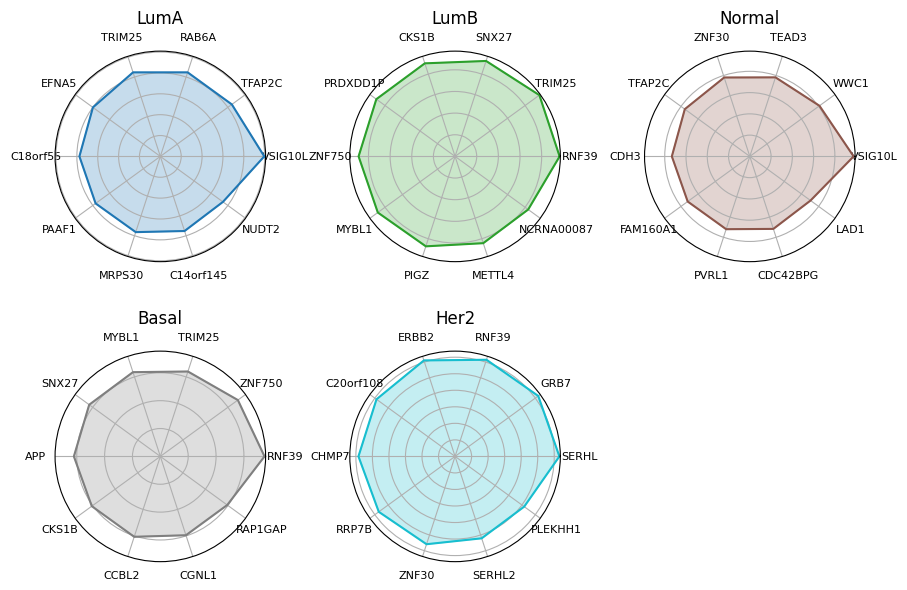

In [53]:
# Check the most

plot_saliency_radar(
    class_saliency=saliency_by_class,
    top_n=10,  # or 15
    gene_names=[gene.split("|")[0] for gene in gene_names],
    id_to_type={v:k for k, v in class_map.item().items()},
    ncol=3, figsize=(10, 10)
)